# Predspracovanie údajov
### Projekt z predmetu Inteligentná analýza údajov
#### Martin L. Zachar, Štefan Šebeň

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline


pd.set_option('display.max_columns', 50)

In [2]:
train_data = pd.read_csv('data/explorovane.csv', index_col='id')
train_data.head()

,age,on thyroxine,query on thyroxine,pregnant,thyroid surgery,I131 treatment,lithium,goitre,tumor,hypopituitary,TSH,T3 measured,T3,TT4,T4U,FTI measured,TBG measured,TBG,referral source,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country,date_of_birth,TSH measured,sex,query hyperthyroid,TT4 measured,on antithyroid medication,FTI,sick,T4U measured,psych,query hypothyroid,test,testID
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,82.0,f,f,f,f,f,f,f,f,f,2.2,t,1.0,68.0,0.77,t,f,NaN,SVI,Local-gov,141649,Assoc-voc,11,Married-civ-spouse,Protective-serv,Husband,White,0,0,40,United-States,1935-05-20 00:00:00,t,M,f,t,f,88.0,f,t,f,f,negative,991
1,50.0,f,f,f,t,f,f,f,f,f,76.0,t,0.5,22.0,1.12,t,f,NaN,other,Local-gov,177599,Bachelors,13,Divorced,Prof-specialty,Unmarried,White,0,0,35,United-States,67-08-03,t,F,f,t,f,19.0,f,t,f,f,negative,1685
2,41.0,f,f,f,f,f,f,f,f,f,NaN,t,2.0,99.0,0.96,t,f,NaN,other,Self-emp-not-inc,102631,Some-college,10,Widowed,Farming-fishing,Unmarried,White,0,0,50,United-States,1976-05-02,f,F,f,t,f,104.0,f,t,f,f,negative,3504
3,73.0,f,f,f,f,f,f,f,f,f,0.7,t,2.0,116.0,0.99,t,f,NaN,other,private,272338,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,0,0,25,United-States,44-10-08,t,F,f,t,f,117.0,f,t,f,f,negative,1942
4,64.0,f,f,f,f,f,f,f,f,f,2.0,t,1.8,80.0,0.91,t,f,NaN,SVHC,Self-emp-inc,368825,Some-college,10,Married-civ-spouse,Sales,Husband,White,0,0,60,United-States,1953-05-01,t,M,f,t,f,88.0,f,t,f,f,negative,2009


Zrušíme stĺpce, ktoré neprispejú ku klasifikácii.

In [3]:
train_data = train_data.drop(['TBG measured', 'TBG', 'education', 'testID'], axis=1)

In [4]:
import re

dates = train_data['date_of_birth'].dropna()
dates = list(map(lambda s: re.split(' |-|/|:', s) ,dates))

print("Neidentifikovatelne: ", len(list(filter(lambda d: int(d[0]) <= 31 and int(d[2]) <= 31, dates))))
print("Rok bez uvodnych cisel: ", len(list(filter(lambda d: int(d[0]) < 1900 and int(d[0]) > 31 and int(d[2]) <= 31, dates))))
print("Vymeneny rok a den: ", len(list(filter(lambda d: int(d[0]) <= 31 and int(d[2]) > 1900, dates))))
print("Zly mesiac: ", len(list(filter(lambda d: int(d[1]) > 12, dates))))
print("S casom dna: ", len(list(filter(lambda d: len(d) > 3, dates))))        

Neidentifikovatelne:  5
Rok bez uvodnych cisel:  189
Vymeneny rok a den:  180
Zly mesiac:  0
S casom dna:  382


Pridáme nové stĺpce pre rok a mesiac. Istá sezónnosť v rámci mesiacov roka nemusí byť nutne vylúčená (vplyvy počasia a podnebia apod.), podobne mohol mať teoreticky vplyv aj rok narodenia.

In [5]:
train_data['birth_year'] = np.nan
train_data['birth_month'] = np.nan

In [6]:
for i in range(train_data.shape[0]-1):
    if (pd.isna(train_data.loc[i]['date_of_birth'])):
        continue
    date = list(map(int, re.split(' |-|/|:', train_data.iloc[i]['date_of_birth'])))
    if date[0] <= 31 and date[2] <= 31:
        continue
    elif date[0] <= 31 and date[2] > 31:
        b = date[2]
        date[2] = date[0]
        date[0] = b
    if date[0] < 1900:
        if int(str(date[0])[-2:]) < 18:
            date[0] = date[0] + 2000 - int(str(date[0])[:-2] if str(date[0])[:-2] != '' else 0) * 100
        else:
            date[0] = date[0] + 1900 - int(str(date[0])[:-2] if str(date[0])[:-2] != '' else 0) * 100
    if len(date) > 3:
        date = date[:3]
    train_data.loc[i, 'birth_year'] = date[0]
    train_data.loc[i, 'birth_month'] = date[1]
    
train_data.head()

,age,on thyroxine,query on thyroxine,pregnant,thyroid surgery,I131 treatment,lithium,goitre,tumor,hypopituitary,TSH,T3 measured,T3,TT4,T4U,FTI measured,referral source,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country,date_of_birth,TSH measured,sex,query hyperthyroid,TT4 measured,on antithyroid medication,FTI,sick,T4U measured,psych,query hypothyroid,test,birth_year,birth_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,82.0,f,f,f,f,f,f,f,f,f,2.2,t,1.0,68.0,0.77,t,SVI,Local-gov,141649,11,Married-civ-spouse,Protective-serv,Husband,White,0,0,40,United-States,1935-05-20 00:00:00,t,M,f,t,f,88.0,f,t,f,f,negative,1935.0,5.0
1,50.0,f,f,f,t,f,f,f,f,f,76.0,t,0.5,22.0,1.12,t,other,Local-gov,177599,13,Divorced,Prof-specialty,Unmarried,White,0,0,35,United-States,67-08-03,t,F,f,t,f,19.0,f,t,f,f,negative,1967.0,8.0
2,41.0,f,f,f,f,f,f,f,f,f,NaN,t,2.0,99.0,0.96,t,other,Self-emp-not-inc,102631,10,Widowed,Farming-fishing,Unmarried,White,0,0,50,United-States,1976-05-02,f,F,f,t,f,104.0,f,t,f,f,negative,1976.0,5.0
3,73.0,f,f,f,f,f,f,f,f,f,0.7,t,2.0,116.0,0.99,t,other,private,272338,9,Married-civ-spouse,Adm-clerical,Wife,White,0,0,25,United-States,44-10-08,t,F,f,t,f,117.0,f,t,f,f,negative,1944.0,10.0
4,64.0,f,f,f,f,f,f,f,f,f,2.0,t,1.8,80.0,0.91,t,SVHC,Self-emp-inc,368825,10,Married-civ-spouse,Sales,Husband,White,0,0,60,United-States,1953-05-01,t,M,f,t,f,88.0,f,t,f,f,negative,1953.0,5.0


In [7]:
train_data = train_data.drop(['date_of_birth'], axis=1)

Overíme si, či sa nám správne podarilo opraviť všetky hodnoty.

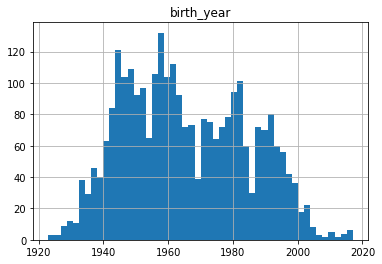

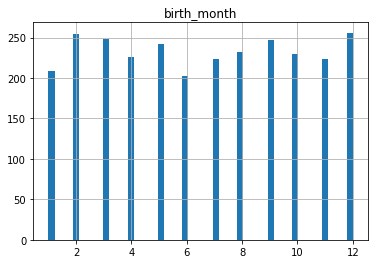

In [8]:
pd.Series(train_data['birth_year']).hist(bins=50).set_title("birth_year")
plt.figure()
pd.Series(train_data['birth_month']).hist(bins=50).set_title("birth_month")
plt.figure()

Zlúčime rozdielne zapísané hodnoty atribútov s totožným významom.

In [9]:
for i in range(train_data.shape[0]):
    if train_data.loc[i, 'on thyroxine'] == 'FALSE' or train_data.loc[i, 'on thyroxine'] == 'F':
        train_data.loc[i, 'on thyroxine'] = 'f'
    elif train_data.loc[i, 'on thyroxine'] == 'TRUE' or train_data.loc[i, 'on thyroxine'] == 'T':
        train_data.loc[i, 'on thyroxine'] = 't'
    
    for col in train_data.columns[train_data.dtypes == np.object]:
        if pd.notna(train_data.loc[i, col]):
            train_data.loc[i, col] = train_data.loc[i, col].lower().strip()

In [10]:
for column in train_data.columns[train_data.dtypes == np.object]:
    if train_data[column].unique().size < 50:
        print(train_data[column].value_counts())
        print()

f    2470
t     330
Name: on thyroxine, dtype: int64

f    2760
t      40
Name: query on thyroxine, dtype: int64

f    2759
t      41
Name: pregnant, dtype: int64

f    2761
t      39
Name: thyroid surgery, dtype: int64

f    2752
t      48
Name: I131 treatment, dtype: int64

f    2786
t      14
Name: lithium, dtype: int64

f    2775
t      25
Name: goitre, dtype: int64

f    2729
t      71
Name: tumor, dtype: int64

f    2799
t       1
Name: hypopituitary, dtype: int64

t    2215
f     585
Name: T3 measured, dtype: int64

t    2505
f     295
Name: FTI measured, dtype: int64

other    1632
svi       771
svhc      275
stmw       91
svhd       31
Name: referral source, dtype: int64

private             1974
local-gov            212
self-emp-not-inc     178
?                    169
state-gov            123
federal-gov           75
self-emp-inc          69
Name: workclass, dtype: int64

never-married            1118
married-civ-spouse        853
divorced                  489
widowed       

Pripravili sme si funkciu na nahradzovanie stĺpca datasetu jeho trnasformáciu pomocou box-cox algoritmu. Táto funckia počíta s tým, že stĺpec môže obsahovať ešte neznáme hodnoty. Urobili sme tomu tak preto, aby sme nemusili dopĺňať neznáme hodnoty ešte predtým, než nahradíme odľahlé hodnoty, ktoré môžu ovplyvniť nahradzované hodnoty.

In [11]:
from scipy.stats import boxcox
from functools import reduce

def replaceWithBC(data, attr):
    bc, att = boxcox(data[attr].dropna())
    i2 = 0
    for i in range(data.shape[0]):
        if pd.notna(data.loc[i, attr]):
            data.loc[i, attr] = bc[i2]
            i2 = i2 + 1
            
def replaceOutliers(data, attr, thrshl, new):
    for i in range(data.shape[0]):
        if thrshl(data.loc[i, attr]):
            data.loc[i, attr] = new

Pripravili sme si slovník do ktorého sa zapíše unikátnosť hodnôt jednotlivých atribútov. Toto budeme využívať pri dodatočnej identifikácii outlierov...

In [12]:
uniquenesstable = {}
def updateUniquenesstable():
    for column in train_data.columns[train_data.dtypes == np.object]:
        unique = train_data[column].unique()
        uniquenesstable[column] = {}
        for u in unique:
            uniquenesstable[column][u] = len(train_data[train_data[column] == u][column]) / len(train_data[column])
        uniquenesstable[column]['expected'] = 1 / len(unique)

    for column in train_data.columns:
        if np.issubdtype(train_data[column].dtype, np.number):
            uniquenesstable[column] = {}
            uniquenesstable[column]['mean'] = train_data[column].mean()
            uniquenesstable[column]['median'] = train_data[column].median()
            uniquenesstable[column]['std'] = train_data[column].std()
            
updateUniquenesstable()

... a taktiež aj funkciu, ktorá tieto unikátne hodnoty vypíše.

In [13]:
def printUnique(data, attr, f):
    outs = data[f(data[attr])]
    c = 0
    for i in range(outs.shape[0]):
        un = False
        for col in data.columns:
            out = outs.iloc[i]
            if not pd.isna(out[col]):
                if np.issubdtype(train_data[col].dtype, np.number):
                    if out[col] < uniquenesstable[col]['mean'] - uniquenesstable[col]['std'] or out[col] > uniquenesstable[col]['mean'] + uniquenesstable[col]['std']:
                        print(i, attr, out[attr], col, out[col], uniquenesstable[col]['mean'])
                        un = True
                    elif out[col] < uniquenesstable[col]['median'] - uniquenesstable[col]['std'] or out[col] > uniquenesstable[col]['median'] + uniquenesstable[col]['std']:
                        print(i, attr, out[attr], col, out[col], uniquenesstable[col]['median'])
                        un = True
                else:
                    if uniquenesstable[col][out[col]] < uniquenesstable[col]['expected'] / 2:
                        print(i, attr, out[attr], col, out[col], uniquenesstable[col][out[col]], uniquenesstable[col]['expected'])
                        un = True
        if (un):
            c = c + 1
    print("Unikátnych", c, "z", outs.shape[0])

Pomôžeme si aj korelačnou tabuľkou, ktorú sme prevzali z prechádzajúceho dokumentu.

age - T3  correlation:  -0.24237972891474738
age - birth_year  correlation:  -0.9211649983991632
TSH - TT4  correlation:  -0.2685525331664122
TSH - FTI  correlation:  -0.291188373868199
T3 - TT4  correlation:  0.5660571765652239
T3 - T4U  correlation:  0.46343405909602275
T3 - FTI  correlation:  0.3510133883173405
T3 - birth_year  correlation:  0.2686637335777969
TT4 - T4U  correlation:  0.4339389434445414
TT4 - FTI  correlation:  0.798007458309882


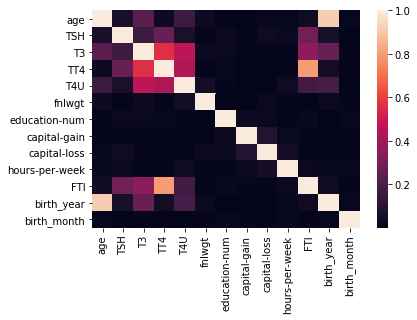

In [14]:
for i in range(train_data.shape[1]):
    if np.issubdtype(train_data[train_data.columns[i]].dtype, np.number):
        for i2 in range(i, train_data.shape[1]):
            if np.issubdtype(train_data[train_data.columns[i2]].dtype, np.number):
                corr = train_data[train_data.columns[i]].corr(train_data[train_data.columns[i2]])
                if (corr > 0.2 or corr < -0.2) and train_data.columns[i] != train_data.columns[i2]:
                    print(train_data.columns[i], "-", train_data.columns[i2], " correlation: ", train_data[train_data.columns[i]].corr(train_data[train_data.columns[i2]]))

corr = train_data.corr()
seaborn.heatmap(abs(corr), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

TSH malo distribúciu hodnôt pomerne značne roztiahnutú do jednej strany, avšak boli možné pozorovať náznaky toho, že sa snaží mať normálnu distribúciu. Použijeme teda box-cox, aby sme sa pokúsili túto normálnu distriúciu dosiahnúť. 

Po úprave pomocou box-cox algoritmu sú viditeľne hodnoty koncentrovanejšie ako pri neupravovnom atribúte a aj symetrickejšie. Je však možné aj vidieť, že úplná normálna distribúcia dosiahnutá nebola a stále sú hodnoty na ľavej strane od vrcholu distribúcie viac hustejšie naukladané ako na pravej strane, čomu bolo rovnako aj pri pôvodnej distribúcii. Nahradíme teda atribút TSH jeho box-cox verziou a atribút aj patrične premenujeme.

In [15]:
bc, att = boxcox(train_data['TSH'].dropna())
print("Skewness TSH orig: ", stats.skew(train_data['TSH'].dropna()))
print("Skewness TSH box-cox: ", stats.skew(bc))
print("Kurtosis TSH orig: ", stats.kurtosis(train_data['TSH'].dropna()))
print("Kurtosis TSH box-cox: ", stats.kurtosis(bc))

Skewness TSH orig:  14.824564019675963
Skewness TSH box-cox:  0.05058391985348052
Kurtosis TSH orig:  284.54408349616324
Kurtosis TSH box-cox:  1.2940121811098484


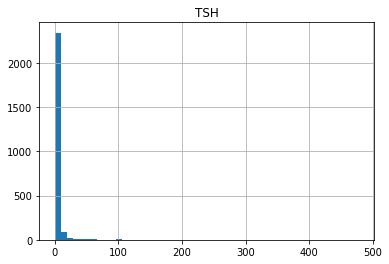

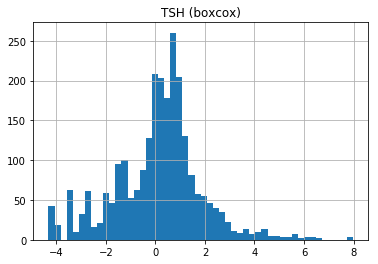

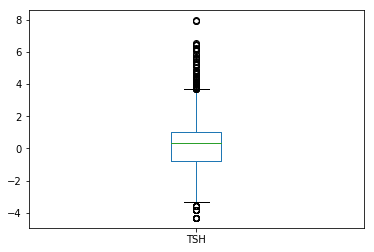

In [16]:
pd.Series(train_data['TSH']).hist(bins=50).set_title("TSH")
plt.figure()
replaceWithBC(train_data, 'TSH')
pd.Series(train_data['TSH']).hist(bins=50).set_title("TSH (boxcox)")
plt.figure()
pd.Series(train_data['TSH']).plot(kind='box')
plt.figure()

updateUniquenesstable()

Vidíme, že subjekty s nameraným vysokým TSH majú zároveň aj pomerne nízke FTI a TT4, čo je možné povšimnúť si aj v korelačnej tabuľke. Keby sme teda tieto domnelo vychýlené hodnoty upravili či odstránili, mohli by sme oslabiť koreláciu týchto atribútov. Nebudeme teda považovať žiadne hodnoty TSH za vychýlené.

In [17]:
printUnique(train_data, 'TSH', lambda x: x > 7.9)

0 TSH 7.970062271875442 age 18.0 51.79356887653831
0 TSH 7.970062271875442 on thyroxine t 0.11785714285714285 0.5
0 TSH 7.970062271875442 TSH 7.970062271875442 0.12403982275038332
0 TSH 7.970062271875442 T3 measured f 0.20892857142857144 0.5
0 TSH 7.970062271875442 T4U 1.3 0.9979121054734323
0 TSH 7.970062271875442 workclass federal-gov 0.026785714285714284 0.14285714285714285
0 TSH 7.970062271875442 relationship other-relative 0.03678571428571428 0.16666666666666666
0 TSH 7.970062271875442 FTI 34.0 110.78798403193613
0 TSH 7.970062271875442 birth_year 1999.0 1965.5130683852487
0 TSH 7.970062271875442 birth_month 11.0 6.538847117794486
1 TSH 7.949412739416855 age 2.0 51.79356887653831
1 TSH 7.949412739416855 TSH 7.949412739416855 0.12403982275038332
1 TSH 7.949412739416855 TT4 34.0 108.99039115646256
1 TSH 7.949412739416855 referral source stmw 0.0325 0.2
1 TSH 7.949412739416855 marital-status married-spouse-absent 0.01892857142857143 0.14285714285714285
1 TSH 7.949412739416855 native-

T3 nebudeme nahradzovať s box-cox, k normalizácii jeho distribúcie by to výrazne neprispelo. Overíme si však, či podozrivá hodnota nad 10 nie je vychýlenou hodnotou.

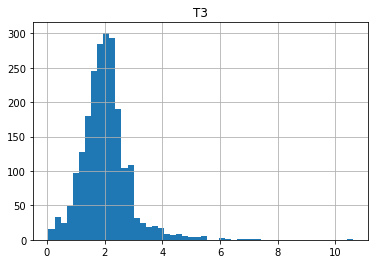

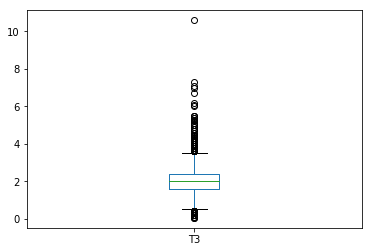

In [18]:
pd.Series(train_data['T3']).hist(bins=50).set_title("T3")
plt.figure()
pd.Series(train_data['T3']).plot(kind='box')
plt.figure()

Vskutku sa zdá, že táto hodnota môže byť valídna, vzhľadom na extrémne hodnoty namerané i u ostatných atribútov. Zistenie potvrdzuje i korelačná tabuľka. Nebudeme s ňou manipulovať z rovnakých dôvodov, ako sme uviedli pri TSH.

In [19]:
printUnique(train_data, 'T3', lambda x: x > 10)

0 T3 10.6 age 77.0 51.79356887653831
0 T3 10.6 TSH -3.568818698884796 0.12403982275038332
0 T3 10.6 T3 10.6 2.024966139954856
0 T3 10.6 TT4 226.0 108.99039115646256
0 T3 10.6 T4U 0.65 0.9979121054734323
0 T3 10.6 FTI 349.0 110.78798403193613
0 T3 10.6 birth_year 1940.0 1965.5130683852487
Unikátnych 1 z 1


Nezdá sa, že by distribúciu TT4 bolo nutné upravovať. Overíme si odľahlé hodnoty nad 400.

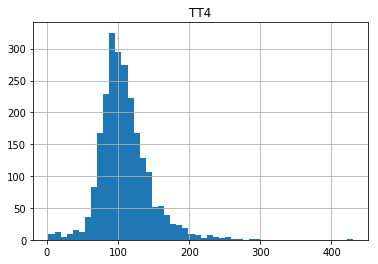

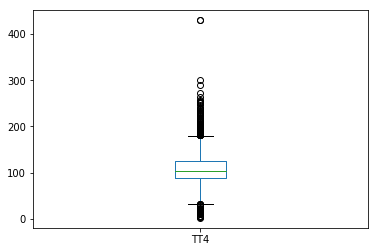

In [20]:
pd.Series(train_data['TT4']).hist(bins=50).set_title("TT4")
plt.figure()
pd.Series(train_data['TT4']).plot(kind='box')
plt.figure()

Ani tieto hodnoty nie sú samé, ktoré sa zdajú byť odľahlé. Je teda pravdepodobnejšie, že sú valídne. Korelačná tabuľka tvrdí to isté.

In [21]:
printUnique(train_data, 'TT4', lambda x: x > 400)

0 TT4 430.0 pregnant t 0.014642857142857143 0.5
0 TT4 430.0 TSH -1.5104393060023016 0.3410268735877535
0 TT4 430.0 T3 measured f 0.20892857142857144 0.5
0 TT4 430.0 TT4 430.0 108.99039115646256
0 TT4 430.0 referral source stmw 0.0325 0.2
0 TT4 430.0 fnlwgt 46401 185980.77535714285
0 TT4 430.0 query hyperthyroid t 0.061785714285714284 0.5
0 TT4 430.0 FTI 395.0 110.78798403193613
1 TT4 430.0 TSH -1.7605906784915695 0.12403982275038332
1 TT4 430.0 T3 7.3 2.024966139954856
1 TT4 430.0 TT4 430.0 108.99039115646256
1 TT4 430.0 referral source stmw 0.0325 0.2
1 TT4 430.0 query hyperthyroid t 0.061785714285714284 0.5
1 TT4 430.0 FTI 395.0 110.78798403193613
Unikátnych 2 z 2


Pri T4U sa nenachádza hodnota, ktorú by sme vizuálne zhodnotili za odľahlú, distribúcia je pomerne súvislá, upravovať ju nebudeme.

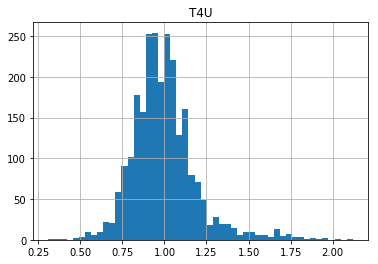

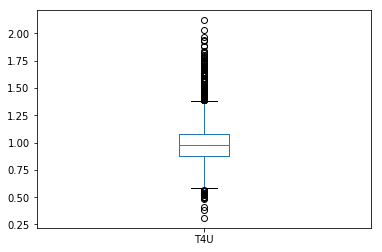

In [22]:
pd.Series(train_data['T4U']).hist(bins=50).set_title("T4U")
plt.figure()
pd.Series(train_data['T4U']).plot(kind='box')
plt.figure()

Pri FTI by sa použitím box-cox taktiež distribúcia priveľmi nepopravila bližšie k normálnej. Vyskúšame, či hodnoty nad 270 nie sú odľahlé.

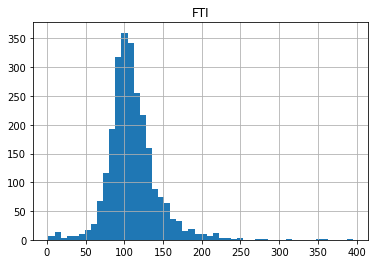

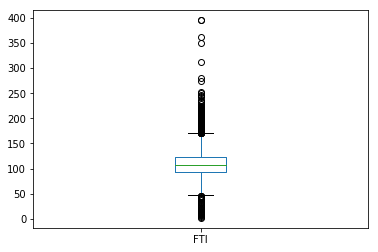

In [23]:
pd.Series(train_data['FTI']).hist(bins=50).set_title("FTI")
plt.figure()
pd.Series(train_data['FTI']).plot(kind='box')
plt.figure()

Aj u FTI je možné pozorovať, že zdanlivo odľahlé hodnoty sa konzistentne upravujú podľa zistených korelácií. Nebudeme ich meniť.

In [24]:
printUnique(train_data, 'FTI', lambda x: x > 270)

0 FTI 274.0 TSH -3.854253878097603 0.12403982275038332
0 FTI 274.0 T3 5.5 2.024966139954856
0 FTI 274.0 TT4 219.0 108.99039115646256
0 FTI 274.0 T4U 0.8 0.9979121054734323
0 FTI 274.0 workclass state-gov 0.04392857142857143 0.14285714285714285
0 FTI 274.0 fnlwgt 19395 185980.77535714285
0 FTI 274.0 query hyperthyroid t 0.061785714285714284 0.5
0 FTI 274.0 FTI 274.0 110.78798403193613
1 FTI 395.0 pregnant t 0.014642857142857143 0.5
1 FTI 395.0 TSH -1.5104393060023016 0.3410268735877535
1 FTI 395.0 T3 measured f 0.20892857142857144 0.5
1 FTI 395.0 TT4 430.0 108.99039115646256
1 FTI 395.0 referral source stmw 0.0325 0.2
1 FTI 395.0 fnlwgt 46401 185980.77535714285
1 FTI 395.0 query hyperthyroid t 0.061785714285714284 0.5
1 FTI 395.0 FTI 395.0 110.78798403193613
2 FTI 349.0 age 77.0 51.79356887653831
2 FTI 349.0 TSH -3.568818698884796 0.12403982275038332
2 FTI 349.0 T3 10.6 2.024966139954856
2 FTI 349.0 TT4 226.0 108.99039115646256
2 FTI 349.0 T4U 0.65 0.9979121054734323
2 FTI 349.0 FTI 349

Distribúcia atribútu fnlwgt pôsobí "useknuto" a na jednej strane rozťahane. Pokúsime sa ju znormalizovať pomocou box-cox algoritmu.

Použitie box-cox viditeľne pomohlo zosymetrizovať distribúciu atribútu fnlwgt, podobne však ako u TSH sa nepodarilo dosiahnúť úplnú symetricitu, či normálne rozdelenie. Hodnoty sú však aj značne koncentrovanejšie a keďže hodnoty atribútu fnlwgt ani nemajú nejakú výraznú výpovednú hodnotu, nebude škodiť, keď fnwgt nahradíme box-cox verziou. 

Bližšie sa pozrieme na hodnoty s váhou vyššou ako 720.

In [25]:
print("Skewness fnlwgt orig: ", stats.skew(train_data['fnlwgt'].dropna()))
print("Skewness fnlwgt box-cox: ", stats.skew(bc))
print("Kurtosis fnlwgt orig: ", stats.kurtosis(train_data['fnlwgt'].dropna()))
print("Kurtosis fnlwgt box-cox: ", stats.kurtosis(bc))

Skewness fnlwgt orig:  1.4582578636301344
Skewness fnlwgt box-cox:  0.05058391985348052
Kurtosis fnlwgt orig:  5.76294202332816
Kurtosis fnlwgt box-cox:  1.2940121811098484


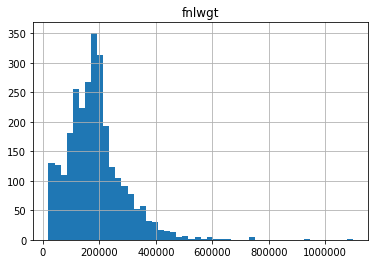

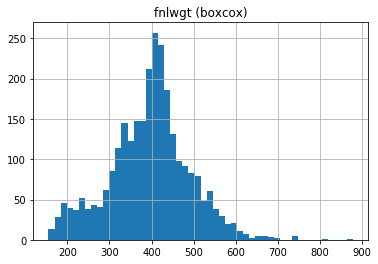

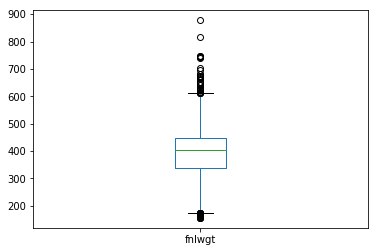

In [26]:
pd.Series(train_data['fnlwgt']).hist(bins=50).set_title("fnlwgt")
plt.figure()
replaceWithBC(train_data, 'fnlwgt')
pd.Series(train_data['fnlwgt']).hist(bins=50).set_title("fnlwgt (boxcox)")
plt.figure()
pd.Series(train_data['fnlwgt']).plot(kind='box')
plt.figure()

updateUniquenesstable()

I keď takmer každá z týchto vysokých hodnôt fnlwgt má nejaký iný atribút pomerne unikátny, nie je tu vidieť nijaká konzistencia, t.j. že niektorý z iných atribútov je pri každej z týchto hodnôt atribútu fnlwgt výnimočný. Odpovedá to zisteniam z prieskumnej analýzy, kde sme zistili najviac chabú súvislosť s atribptmi race, occupation a marital-status, pričom ani tieto nefigurujú vo vyššom počte v nižšie uvedenom výpise unikátnosti hodnôt. 

Všetko toto spolu značí, že s vysokou pravdepodobnosťou možno upraviť tieto odľahlé hodnoty bez výrazného dopadu na prípadné korelácie tohto atribútu s inými. Použijeme pritom stratégiu nahradzovaním 95-percentným kvartilom, keďže táto sa nám zdá byť sympatickejšia voči odstraňovaniu. Odstránenie by však taktiež nebolo veľkým krokom vedľa, pretože žiadne z uvedených pozorovaní nie je oslňujúco unikátne svojimi hodnotami a ani nesúvisí s atribútom, voči ktorému budeme klasifikovať.

In [27]:
printUnique(train_data, 'fnlwgt', lambda x: x > 720)

0 fnlwgt 745.5596830514392 T3 measured f 0.20892857142857144 0.5
0 fnlwgt 745.5596830514392 fnlwgt 745.5596830514392 395.8140939185308
0 fnlwgt 745.5596830514392 FTI 73.0 110.78798403193613
0 fnlwgt 745.5596830514392 query hypothyroid t 0.05821428571428571 0.5
1 fnlwgt 740.520637388126 age 74.0 51.79356887653831
1 fnlwgt 740.520637388126 T4U 0.8 0.9979121054734323
1 fnlwgt 740.520637388126 fnlwgt 740.520637388126 395.8140939185308
1 fnlwgt 740.520637388126 FTI 152.0 110.78798403193613
1 fnlwgt 740.520637388126 birth_year 1943.0 1965.5130683852487
2 fnlwgt 744.158996157952 T3 measured f 0.20892857142857144 0.5
2 fnlwgt 744.158996157952 FTI measured f 0.10535714285714286 0.5
2 fnlwgt 744.158996157952 fnlwgt 744.158996157952 395.8140939185308
2 fnlwgt 744.158996157952 hours-per-week 15 38.33642857142857
2 fnlwgt 744.158996157952 TSH measured f 0.10142857142857142 0.5
2 fnlwgt 744.158996157952 TT4 measured f 0.06571428571428571 0.5
2 fnlwgt 744.158996157952 T4U measured f 0.106071428571428

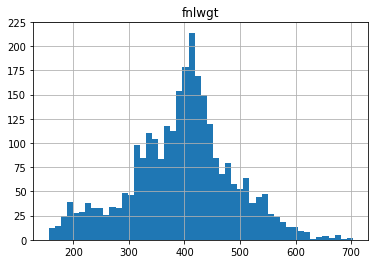

In [28]:
replaceOutliers(train_data, 'fnlwgt', lambda a: a > 720, np.percentile(train_data['fnlwgt'], 95))

pd.Series(train_data['fnlwgt']).hist(bins=50).set_title("fnlwgt")
plt.figure()

Pri hourse-per-week sa pozrieme na subjekty na ostrovčeku s viac ako 95 hodinami za týždeň. Podozrivé sa môžu síce zdať už aj hodnoty nad 60, alebo pod 10, avšak iba tieto hodnoty nad 95 sú výzarne odtrhnuté od ostatných a od chvostov distribúcie.

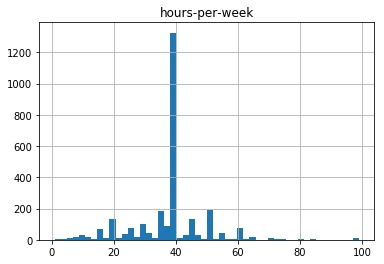

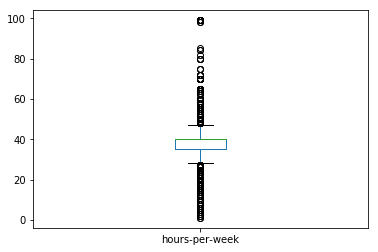

In [29]:
pd.Series(train_data['hours-per-week']).hist(bins=50).set_title("hours-per-week")
plt.figure()
pd.Series(train_data['hours-per-week']).plot(kind='box')
plt.figure()

Pri vysokých hodnotách počtu hodín za týždeň sa jedná prevažne o samozamestaných ľudí, pričom niektorí majú podozrivo vysoký vek vzhľadom na počet odpracovaných hodín. Niektorí majú aj odchýlené niektoré medicínske merania, sú však odchýlené nekonzistentne, takže sa o súvis nejedná - žiaden ani nebol odhalený pri prieskumnej analýze.

Týchto jedenásť hodnôt nahradíme teda 95-percentilom. Opäť, ako pri atribúte fnlwgt, nie je tu žiadna hodnota, ktorá by mala výsledok testu (atribút voči ktorému budeme klasifikovať) nezhodný (tá vzácnejšia hodnota klasifikovaného atribútu), avšak tri či štyry z týchto pozorovaní majú pomerne vysoké namerané hodnoty niektorých z medicínskych meraní, takže by ich možno bolo škoda stratiť odstránením týchto subjektov z dátového súboru.

In [30]:
printUnique(train_data, 'hours-per-week', lambda x: x > 85)

0 hours-per-week 99 T3 measured f 0.20892857142857144 0.5
0 hours-per-week 99 hours-per-week 99 38.33642857142857
0 hours-per-week 99 birth_year 1990.0 1965.5130683852487
0 hours-per-week 99 birth_month 2.0 6.538847117794486
1 hours-per-week 98 workclass self-emp-not-inc 0.06357142857142857 0.14285714285714285
1 hours-per-week 98 fnlwgt 507.3428746196795 395.8140939185308
1 hours-per-week 98 hours-per-week 98 38.33642857142857
2 hours-per-week 99 on thyroxine t 0.11785714285714285 0.5
2 hours-per-week 99 workclass federal-gov 0.026785714285714284 0.14285714285714285
2 hours-per-week 99 fnlwgt 535.2953540287214 395.8140939185308
2 hours-per-week 99 hours-per-week 99 38.33642857142857
2 hours-per-week 99 birth_month 3.0 6.538847117794486
3 hours-per-week 99 TSH -2.1035561988941174 0.12403982275038332
3 hours-per-week 99 T3 measured f 0.20892857142857144 0.5
3 hours-per-week 99 TT4 62.0 108.99039115646256
3 hours-per-week 99 fnlwgt 537.4541713946792 395.8140939185308
3 hours-per-week 99 c

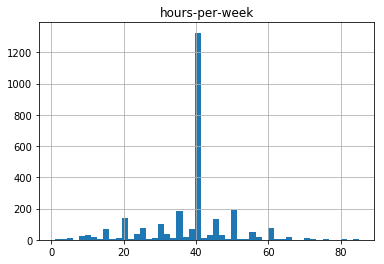

In [31]:
replaceOutliers(train_data, 'hours-per-week', lambda a: a > 95, np.percentile(train_data['hours-per-week'], 95))

pd.Series(train_data['hours-per-week']).hist(bins=50).set_title("hours-per-week")
plt.figure()

Vek s hodnotou 455 rokov je bezpochyby odľahlou hodnotou uvažujúc, že nie je možné sa takého vysokého veku dožiť. Preskúmanie unikátnych hodnôt tohto pozorovania ukázalo, že sa nelíši ničím inakším zvláštnym len samotným vekom. Pri troche nápaditosti si možno domyslieť, že sa vzhľadom na rok narodenia 1962 pozorovania má jednať o vek 55 rokov, takže je túto odľahlú hodnotu ľahké opraviť. V tomto prípade by však ani odstránenie pozorovania neuškodilo, kedže neobsahuje unikátne hodnoty.

In [32]:
printUnique(train_data, 'age', lambda x: x == 455)

0 age 455.0 age 455.0 51.79356887653831
0 age 455.0 workclass state-gov 0.04392857142857143 0.14285714285714285
0 age 455.0 birth_month 12.0 6.538847117794486
Unikátnych 1 z 1


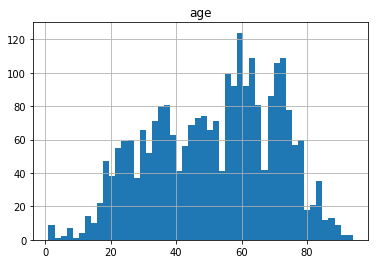

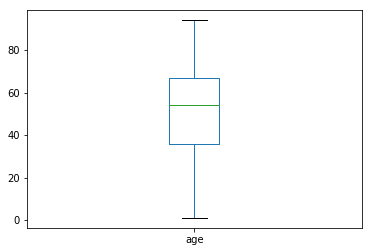

In [33]:
train_data[train_data['age']==455] = 55

pd.Series(train_data['age']).hist(bins=50).set_title("age")
plt.figure()
pd.Series(train_data['age']).plot(kind='box')
plt.figure()

Keďže už máme dátum a mesiac narodenia v číselnej podobe a v atribúte vek sme odstránili odľahlú hodnotu, môžeme si overiť aj to, či sa merania odkazujú na rovnaký dátum.

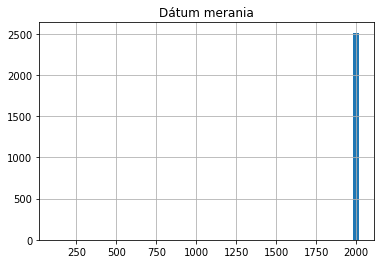

In [34]:
currDate = train_data.birth_year + (train_data.birth_month / 12) + train_data.age

pd.Series(currDate).hist(bins=50).set_title("Dátum merania")
plt.figure()

Zjednotíme rozličné hodnoty edukačného čísla s rovnakým významom. Edukačné číslo budeme používať namiesto samotného kategorického atribútu "education", ktorý sme odstránili.

In [35]:
for i in range (len(train_data['education-num'])):
    if train_data.loc[i, 'education-num'] < 0:
        train_data.loc[i, 'education-num'] *= -1
    if train_data.loc[i, 'education-num'] >= 100:
        train_data.loc[i, 'education-num'] = train_data.loc[i, 'education-num']/100

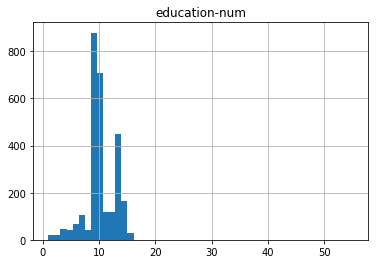

In [36]:
pd.Series(train_data['education-num']).hist(bins=50).set_title("education-num")
plt.figure()

Atribúty capital-gain a capital-loss mali distribúciu, ktorú nebolo možné napraviť do normálnej distribúcie a ani ju prehlásiť za nejakú inú, známu distribúciu. Taktiež viac ako 90 percent hodnôt týchto číslených atribútov nadobúdalo hodnotu 0, žo značí že buď nebola hodnota meraná, alebo pozorovania ani žiadnú takú aktivitu, ktorá by viedla k zmene ich kapitálu nevykazovali. Keďže v takejto podobe nemajú tieto atribúty žiaden pozorovateľný vplyv na ostatné hodnoty dátového súboru, rozhodli sme sa pokúsiť ešte tento atribút upraviť na atribút kategorický, ktorý by nadobúdal tri hodnoty, vyjadrujúce či doľlo k prírastku, úbytku kapirálu, alebo sa kapitál nezmenil. Je možné, že u takto zlúčených hodnotách bude možno nejaký súvis s hodnotami ostatnými atribútov pozorovať.

In [37]:
train_data['yield'] = np.nan
for i in range(train_data.shape[0]):
    yld = train_data.loc[i,'capital-gain'] - train_data.loc[i, 'capital-loss']
    if (yld == 0):
        train_data.loc[i, 'yield'] = 'none'
    elif (yld < 0):
        train_data.loc[i, 'yield'] = 'loss'
    else:
        train_data.loc[i, 'yield'] = 'gain'

In [38]:
train_data = train_data.drop(['capital-gain', 'capital-loss'], axis=1)

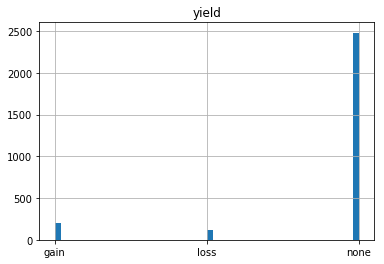

In [39]:
pd.Series(train_data['yield']).hist(bins=50).set_title("yield")
plt.figure()

In [40]:
train_data.head()

,age,on thyroxine,query on thyroxine,pregnant,thyroid surgery,I131 treatment,lithium,goitre,tumor,hypopituitary,TSH,T3 measured,T3,TT4,T4U,FTI measured,referral source,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,hours-per-week,native-country,TSH measured,sex,query hyperthyroid,TT4 measured,on antithyroid medication,FTI,sick,T4U measured,psych,query hypothyroid,test,birth_year,birth_month,yield
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,82.0,f,f,f,f,f,f,f,f,f,0.813772,t,1.0,68.0,0.77,t,svi,local-gov,365.447207,11.0,married-civ-spouse,protective-serv,husband,white,40.0,united-states,t,m,f,t,f,88.0,f,t,f,f,negative,1935.0,5.0,none
1,50.0,f,f,f,t,f,f,f,f,f,5.172593,t,0.5,22.0,1.12,t,other,local-gov,402.661130,13.0,divorced,prof-specialty,unmarried,white,35.0,united-states,t,f,f,t,f,19.0,f,t,f,f,negative,1967.0,8.0,none
2,41.0,f,f,f,f,f,f,f,f,f,NaN,t,2.0,99.0,0.96,t,other,self-emp-not-inc,318.259586,10.0,widowed,farming-fishing,unmarried,white,50.0,united-states,f,f,f,t,f,104.0,f,t,f,f,negative,1976.0,5.0,none
3,73.0,f,f,f,f,f,f,f,f,f,-0.351650,t,2.0,116.0,0.99,t,other,private,483.595580,9.0,married-civ-spouse,adm-clerical,wife,white,25.0,united-states,t,f,f,t,f,117.0,f,t,f,f,negative,1944.0,10.0,none
4,64.0,f,f,f,f,f,f,f,f,f,0.712661,t,1.8,80.0,0.91,t,svhc,self-emp-inc,550.637942,10.0,married-civ-spouse,sales,husband,white,60.0,united-states,t,m,f,t,f,88.0,f,t,f,f,negative,1953.0,5.0,none


Neznáme hodnoty číselných atribútov sa pokúsime nahradiť priemerom, respektíve mediánom hodnôt daného atribútu.

In [41]:
mean_med = train_data.copy()

for column in mean_med.columns:
    if np.issubdtype(mean_med[column].dtype, np.number):
        if mean_med[column].std() / mean_med[column].mean() <= 1:
            mean = mean_med[column].mean()
            for i in range(len(mean_med[column])):
                if (np.isnan(mean_med.loc[i, column])):
                    mean_med.loc[i, column] = mean
        else:
            median = mean_med[column].median()
            for i in range(len(mean_med[column])):
                if (np.isnan(mean_med.loc[i, column])):
                    mean_med.loc[i, column] = median

O to isté sa pokúsime aj využitím lineárnej regresie. Budeme pri tom ale musieť použiť pre necieľové stĺpce aj neznáme hodnoty nahradené priemerom/mediánom vo vyššej bunke, pretože regresia nedokáže pracovať s neznámymi hodnotami a niektoré pozorovania v dátovom súbore obsahujú viac neznámych pozorovaní. Nahradenie týchto priemerom/mediánom sa nám zdalo ako to najmenej poškodzujúce výsledok regresie.

Je možné si povšimnúť, že lineárny model sa najlepšie natrénoval pre atribúty vek, TT4, T4U, FTI a rok narodenia, pri mesiaci narodenia sa ešte drží na ako-takej úrovni, ale pre TSH, T3, fnlwgt a education-num je už presnosť značne nízka a lineárna predikcia pre ne je prakticky nepoužiteľná.

In [42]:
import sklearn.linear_model
import sklearn.model_selection

linreg = train_data.copy()
allNumeric = pd.DataFrame()

for col in train_data.columns:
    if np.issubdtype(train_data[col].dtype, np.number):
        allNumeric[col] = train_data[col].dropna()

for col in train_data.columns:
    if np.issubdtype(train_data[col].dtype, np.number):
        allNumeric = allNumeric.dropna()
        X = allNumeric
        y = allNumeric[col]
        X = X.drop(col, axis=1)
        
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
        
        reg = sklearn.linear_model.LinearRegression()
        reg.fit(X_train, y_train)
        print("Presnosť pre", col, ":", reg.score(X_test, y_test))
        
        notknown = pd.DataFrame()
        for col2 in train_data.columns:
            if np.issubdtype(train_data[col2].dtype, np.number):
                #kvôli neznámym hodnotam v necieľových stĺpcoch musíme použiť odhad neznámych dohnôt priemerom/mediánom
                notknown[col2] = mean_med[col2]
            if col2 == col:
                #iba pre cieľový stĺpec vyberáme dáta z pôvodného súboru, kde sú stále aj neznáme hodnoty
                notknown[col2] = train_data[col2]
        
        notknown = notknown[pd.isna(notknown[col])]
        if (notknown.shape[0] == 0):
            continue
            
        X = notknown
        y = notknown[col]
        X = X.drop(col, axis=1)
                
        y = reg.predict(X)
        
        #postupne dopĺňame neznáme hodnoty hodnotami odhadovanými lineárnou regresiou
        i2 = 0
        for i in range(linreg.shape[0]):
            if (pd.isna(linreg.loc[i, col])):
                linreg.loc[i, col] = y[i2]
                i2 = i2 + 1


Presnosť pre age : 0.9819054656077083
Presnosť pre TSH : 0.3173150414581769
Presnosť pre T3 : 0.38166560912254544
Presnosť pre TT4 : 0.952284434673831
Presnosť pre T4U : 0.9274857576588506
Presnosť pre fnlwgt : -0.03016665025669285
Presnosť pre education-num : 0.02461779432502098
Presnosť pre hours-per-week : 0.014807063286364053
Presnosť pre FTI : 0.9472329851496215
Presnosť pre birth_year : 0.9857939385707002
Presnosť pre birth_month : -21329.19718660743


Odhady zistené pomocou priemeru/mediánu a lineárnou regresiou si navzájom porovnáme. 

Je možné pozorovať, že nahradzovanie priemerom/mediánom pri atribútoch, ktoré dosahovali viac neznámych hodnôt výrazne navyšovalo počet hodnôt uprostred distribúcie atribútu - čo sa dalo očakávať - pričom lineárna regresia pri atribútoch vek a T3 lepšie udržala po oprave pôvodnú distribúciu hodnôt. V prípadoch TSH, TT4, T4U a FTI boli výsledky oboch týchto metód z hľadiska distribúcie hodnôt pomerne podobné, s miernou favorizáciou lineárnej regresie a pri atribútoch fnlwgt, education-num, hrous-per-week mesiac a rok narodenia boli distribúcie vizuálne totožné, čo bolo zapríčinené nízkym počtom chýbajúcich hodnôt pri týchto atribútoch.

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


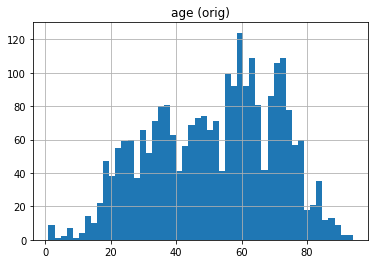

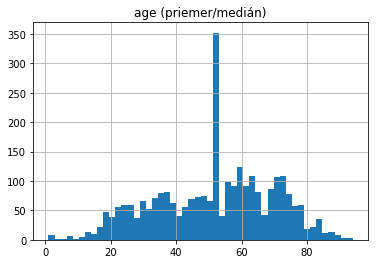

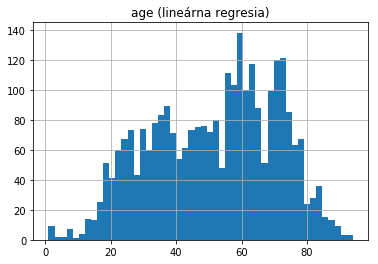

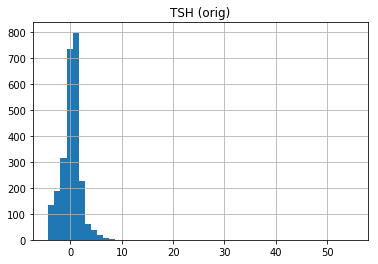

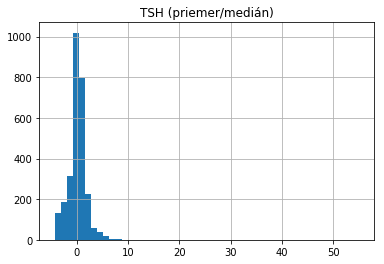

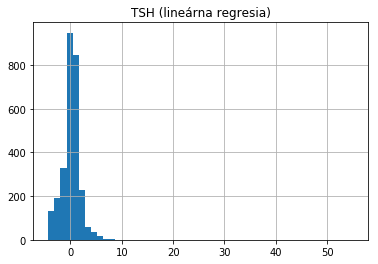

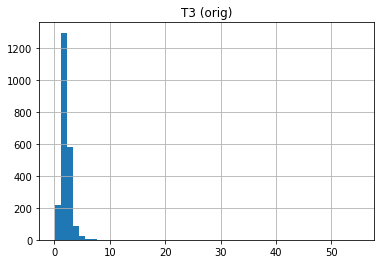

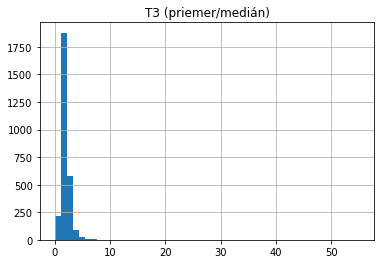

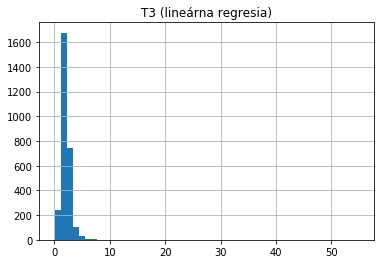

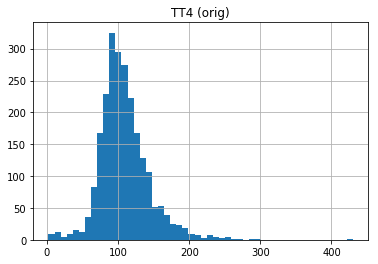

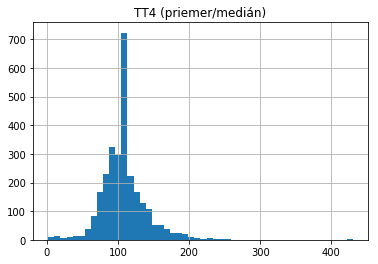

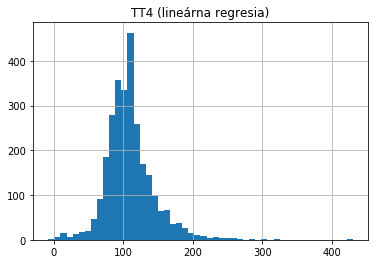

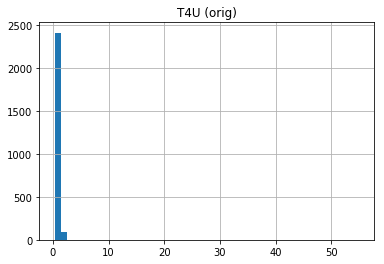

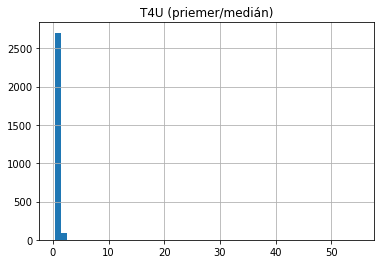

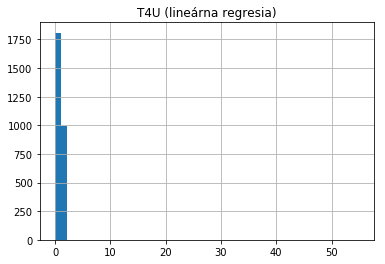

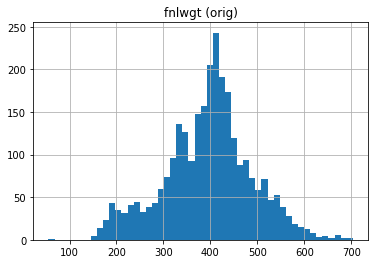

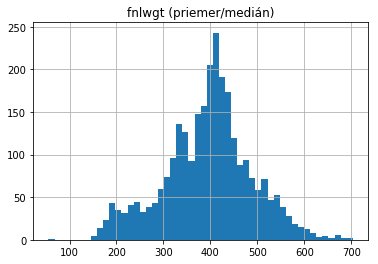

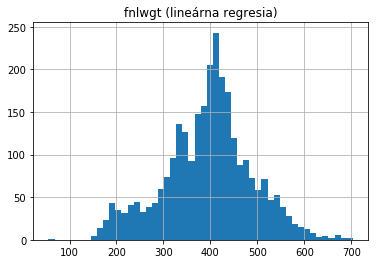

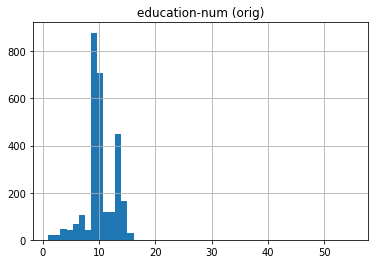

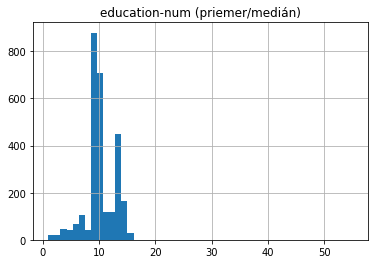

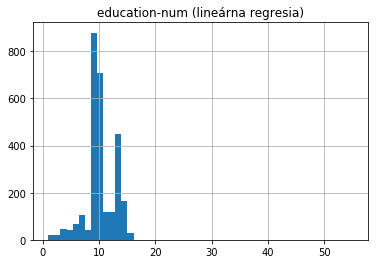

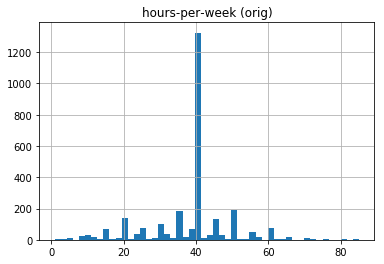

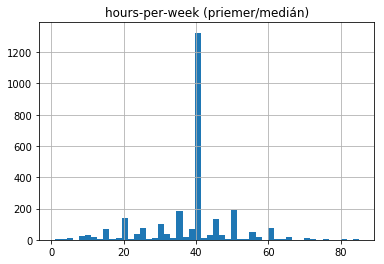

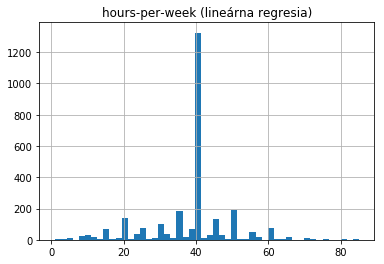

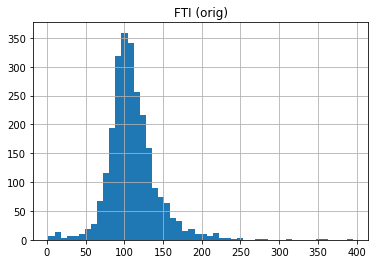

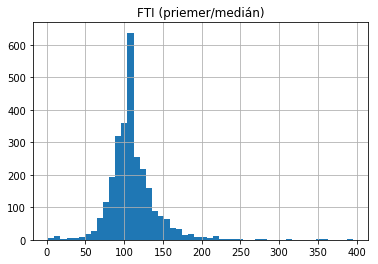

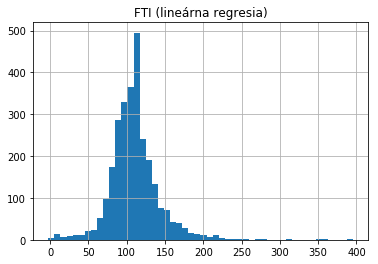

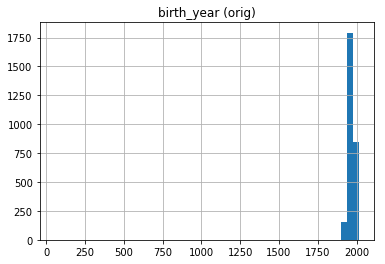

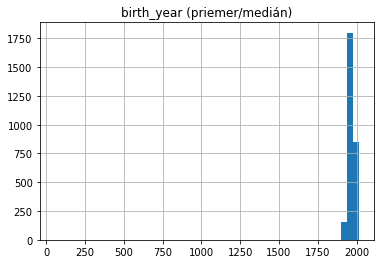

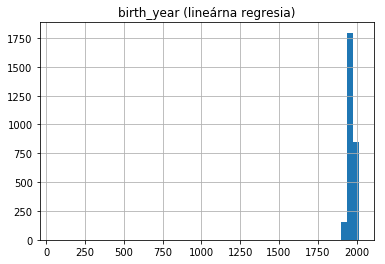

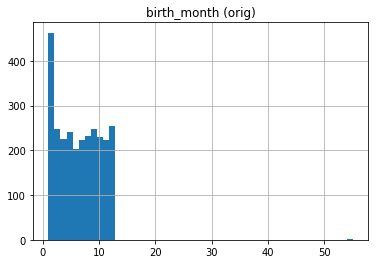

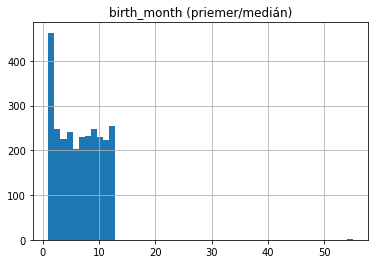

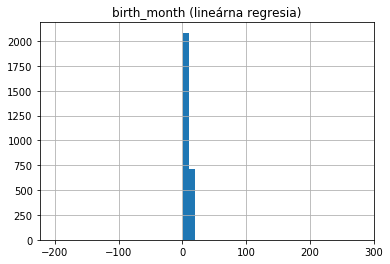

In [43]:
for col in train_data.columns:
    if np.issubdtype(train_data[col].dtype, np.number):
        pd.Series(train_data[col]).hist(bins=50).set_title(col + " (orig)")
        plt.figure()
        pd.Series(mean_med[col]).hist(bins=50).set_title(col + " (priemer/medián)")
        plt.figure()
        pd.Series(linreg[col]).hist(bins=50).set_title(col + " (lineárna regresia)")
        plt.figure()

Čo sa týka deskriptívnych mierok, tak minimá a maximá atribútov boli zachované pri oboch metódach.

In [44]:
train_data.describe()

,age,TSH,T3,TT4,T4U,fnlwgt,education-num,hours-per-week,FTI,birth_year,birth_month
count,2519.000000,2516.000000,2215.000000,2352.000000,2503.000000,2800.000000,2800.000000,2800.000000,2505.000000,2793.000000,2793.000000
mean,51.634776,0.145862,2.048894,108.963605,1.019434,395.158707,10.096429,38.177696,110.768423,1964.830290,6.554243
std,18.903753,2.081516,1.395329,35.639649,1.096757,93.751805,2.576446,11.320362,32.902594,40.800661,3.593015
min,1.000000,-4.321335,0.050000,2.000000,0.310000,55.000000,1.000000,1.000000,2.000000,55.000000,1.000000
25%,36.000000,-0.794684,1.600000,88.000000,0.880000,338.579230,9.000000,35.000000,93.000000,1950.000000,3.000000
50%,54.000000,0.341027,2.000000,104.000000,0.980000,402.288698,10.000000,40.000000,107.000000,1963.000000,7.000000
75%,67.000000,0.992857,2.400000,125.000000,1.080000,447.824789,12.000000,40.000000,124.000000,1981.000000,10.000000
max,94.000000,55.000000,55.000000,430.000000,55.000000,703.319089,55.000000,85.000000,395.000000,2017.000000,55.000000


In [45]:
mean_med.describe()

,age,TSH,T3,TT4,T4U,fnlwgt,education-num,hours-per-week,FTI,birth_year,birth_month
count,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.00000,2800.000000
mean,51.634776,0.165657,2.048894,108.963605,1.015251,395.158707,10.096429,38.177696,110.768423,1964.83029,6.554243
std,17.929758,1.973972,1.240977,32.663167,1.037008,93.751805,2.576446,11.320362,31.120448,40.74961,3.588519
min,1.000000,-4.321335,0.050000,2.000000,0.310000,55.000000,1.000000,1.000000,2.000000,55.00000,1.000000
25%,38.000000,-0.504593,1.700000,91.000000,0.890000,338.579230,9.000000,35.000000,95.000000,1950.00000,3.000000
50%,51.634776,0.341027,2.048894,108.963605,0.980000,402.288698,10.000000,40.000000,110.000000,1963.00000,7.000000
75%,65.000000,0.906752,2.300000,120.000000,1.070000,447.824789,12.000000,40.000000,122.000000,1981.00000,10.000000
max,94.000000,55.000000,55.000000,430.000000,55.000000,703.319089,55.000000,85.000000,395.000000,2017.00000,55.000000


In [46]:
linreg.describe()

,age,TSH,T3,TT4,T4U,fnlwgt,education-num,hours-per-week,FTI,birth_year,birth_month
count,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000
mean,51.684637,0.140825,2.060047,109.092966,1.012078,395.158707,10.096429,38.177696,110.394128,1964.846568,6.660382
std,18.936516,1.981544,1.268734,35.165603,1.040421,93.751805,2.576446,11.320362,32.458201,40.771833,8.610909
min,1.000000,-4.321335,0.050000,-8.092731,-0.072301,55.000000,1.000000,1.000000,-2.302819,55.000000,-200.097275
25%,36.000000,-0.654522,1.600000,89.000000,0.880000,338.579230,9.000000,35.000000,93.000000,1950.000000,3.000000
50%,54.000000,0.265128,2.000000,106.000000,0.986321,402.288698,10.000000,40.000000,108.000000,1963.000000,7.000000
75%,67.000000,0.906752,2.372831,124.000000,1.080000,447.824789,12.000000,40.000000,123.000000,1981.000000,10.000000
max,94.000000,55.000000,55.000000,430.000000,55.000000,703.319089,55.000000,85.000000,395.000000,2017.000000,277.332909


In [47]:
for column in train_data.columns[train_data.dtypes == np.object]:
    for column2 in train_data.columns[train_data.dtypes == np.object]:
        if train_data[column].unique().size < 4 and train_data[column2].unique().size < 4 and column != column2:
            ctab = pd.crosstab(index=train_data[column], columns=train_data[column2], normalize='index')
            non_uniform = False
            for col in ctab.columns:
                vals = [ctab[col][a] for a in range(ctab.shape[0])]
                for i in range(len(vals)):
                    if vals[i] == 1:
                        print(column,":", ctab.index[i], '=> ', column2,":", col)
                        

TypeError: '<' not supported between instances of 'str' and 'int'

translator = {}

for col in train_data.columns[train_data.dtypes == np.object]:
    translator[col] = {}
    un = train_data[col].unique()
    for i in range(len(un)):
        translator[col][un[i]] = i

def translate(data, attr):
    trans = data[attr]
    for i in range(len(trans)):
        trans[i] = translator[attr][trans[i]]
    
    return trans


allNumeric = train_data

for col in train_data.columns[train_data.dtypes == np.object]:
    allNumeric[col] = translate(train_data, col)

In [ ]:
for column in train_data.columns:
    b = train_data[column].isnull()
    c = b[b == True].count()
    if c != 0:
        print(column, ": ", c)